✨ 그래프 저장 완료: ./training_curves_3.png


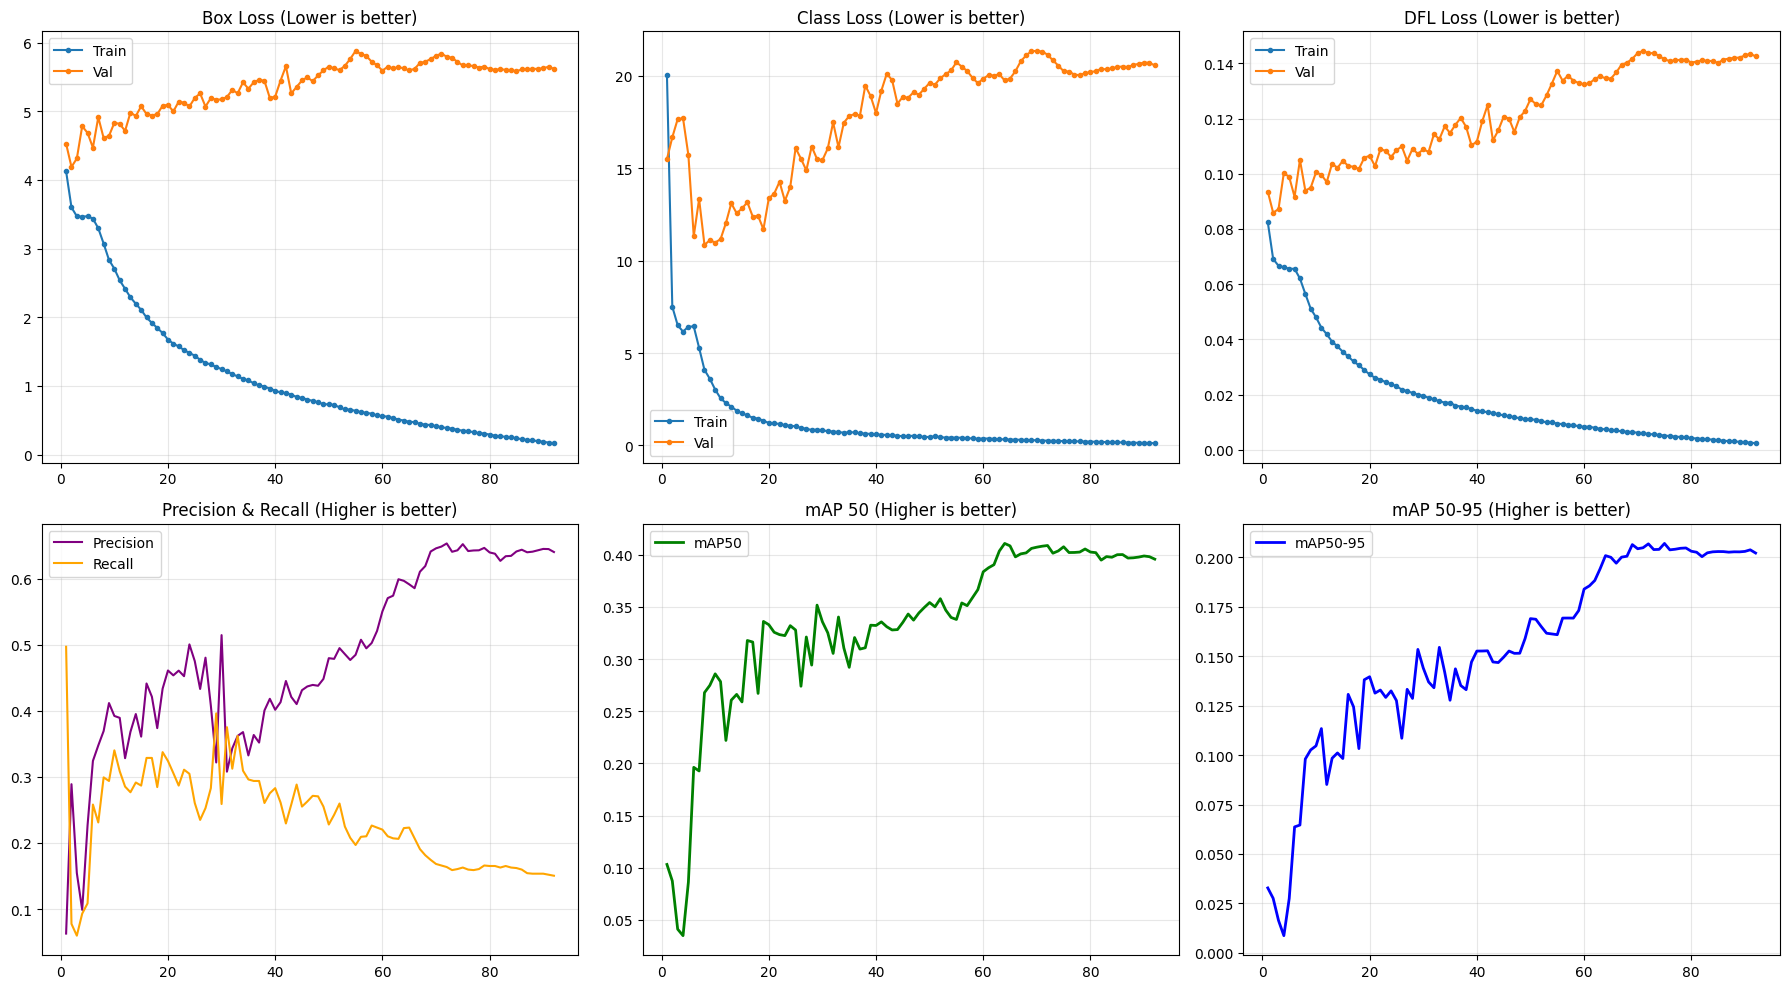

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ==========================================
# [설정] results.csv 경로를 지정하세요
# ==========================================
# 예: runs/rsna_5fold_512/fold_1/results.csv
CSV_PATH = r'./runs/rsna_cropped_3ch_m/fold_1/results.csv' 
SAVE_PATH = r'./training_curves_3.png'

def plot_results():
    if not os.path.exists(CSV_PATH):
        print(f"❌ 파일을 찾을 수 없습니다: {CSV_PATH}")
        return

    # 데이터 로드 (공백 제거)
    df = pd.read_csv(CSV_PATH)
    df.columns = [c.strip() for c in df.columns]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    epochs = df['epoch']

    # 1. Box Loss
    axes[0, 0].plot(epochs, df['train/box_loss'], label='Train', marker='.')
    axes[0, 0].plot(epochs, df['val/box_loss'], label='Val', marker='.')
    axes[0, 0].set_title('Box Loss (Lower is better)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Cls Loss
    axes[0, 1].plot(epochs, df['train/cls_loss'], label='Train', marker='.')
    axes[0, 1].plot(epochs, df['val/cls_loss'], label='Val', marker='.')
    axes[0, 1].set_title('Class Loss (Lower is better)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. DFL Loss
    axes[0, 2].plot(epochs, df['train/dfl_loss'], label='Train', marker='.')
    axes[0, 2].plot(epochs, df['val/dfl_loss'], label='Val', marker='.')
    axes[0, 2].set_title('DFL Loss (Lower is better)')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Precision & Recall
    axes[1, 0].plot(epochs, df['metrics/precision(B)'], label='Precision', color='purple')
    axes[1, 0].plot(epochs, df['metrics/recall(B)'], label='Recall', color='orange')
    axes[1, 0].set_title('Precision & Recall (Higher is better)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. mAP50
    axes[1, 1].plot(epochs, df['metrics/mAP50(B)'], label='mAP50', color='green', linewidth=2)
    axes[1, 1].set_title('mAP 50 (Higher is better)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # 6. mAP50-95
    axes[1, 2].plot(epochs, df['metrics/mAP50-95(B)'], label='mAP50-95', color='blue', linewidth=2)
    axes[1, 2].set_title('mAP 50-95 (Higher is better)')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(SAVE_PATH)
    print(f"✨ 그래프 저장 완료: {SAVE_PATH}")
    plt.show()

if __name__ == '__main__':
    plot_results()

📦 모델 로딩 중: ./runs/rsna_cropped_3ch_m/fold_1/weights/best.pt
🔍 검증 데이터 중 골절 샘플 5개를 추론합니다...


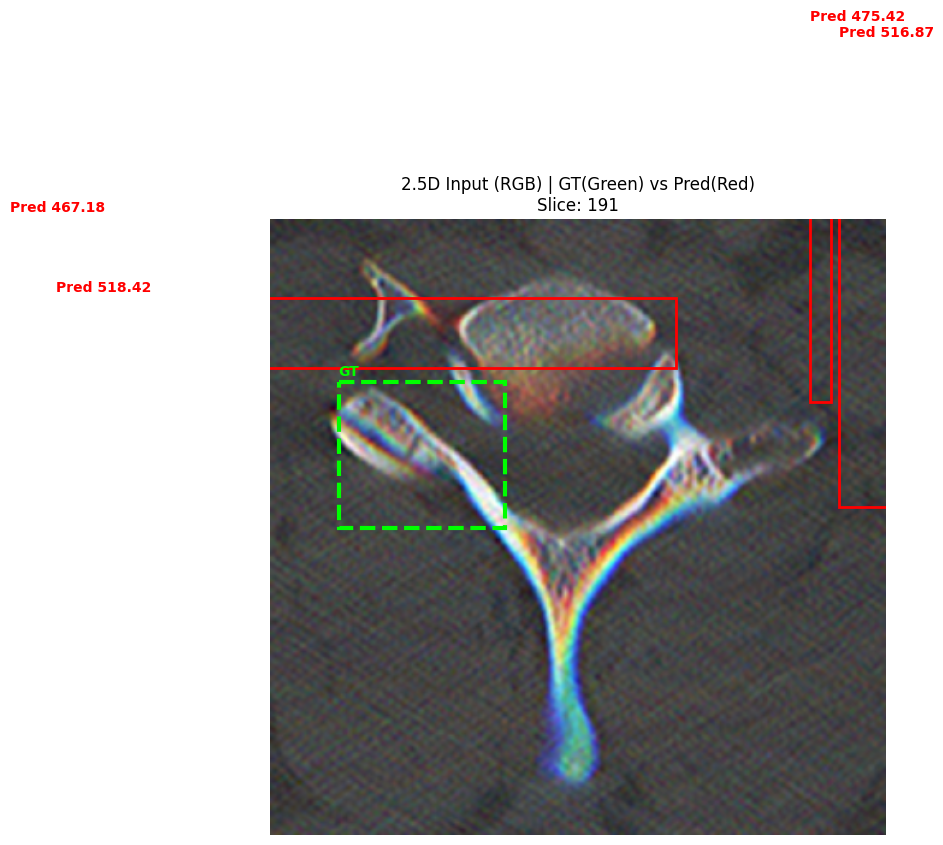

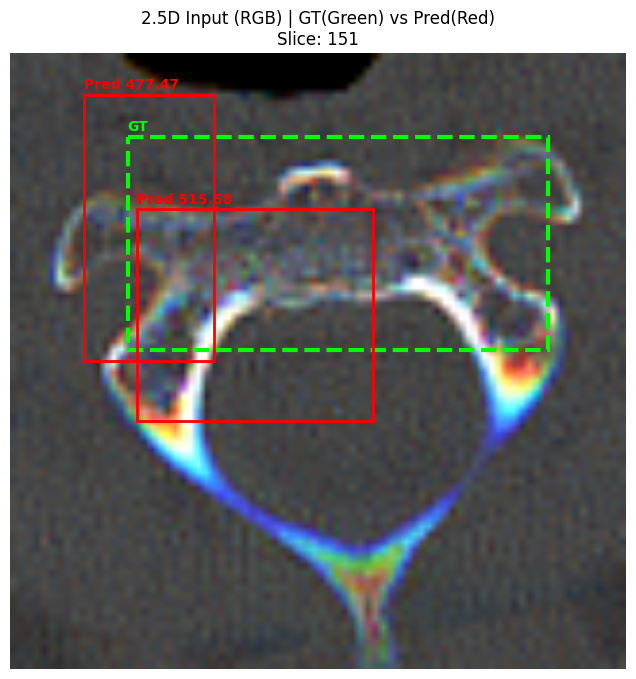

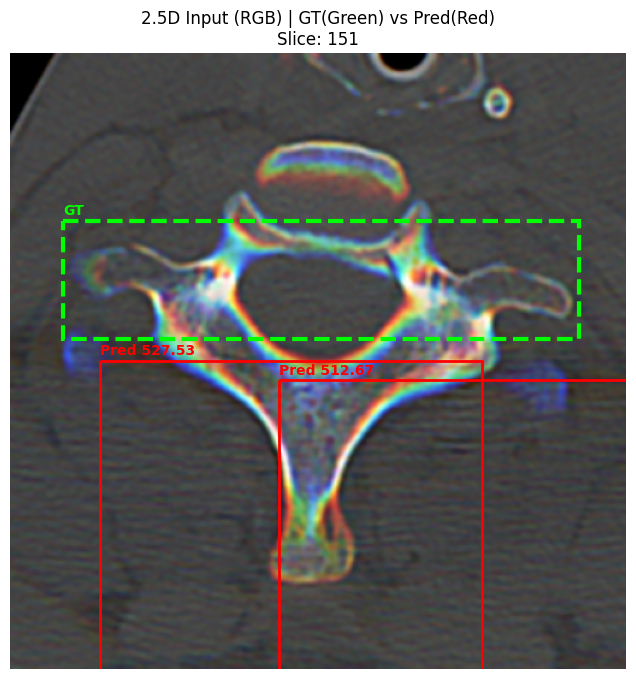

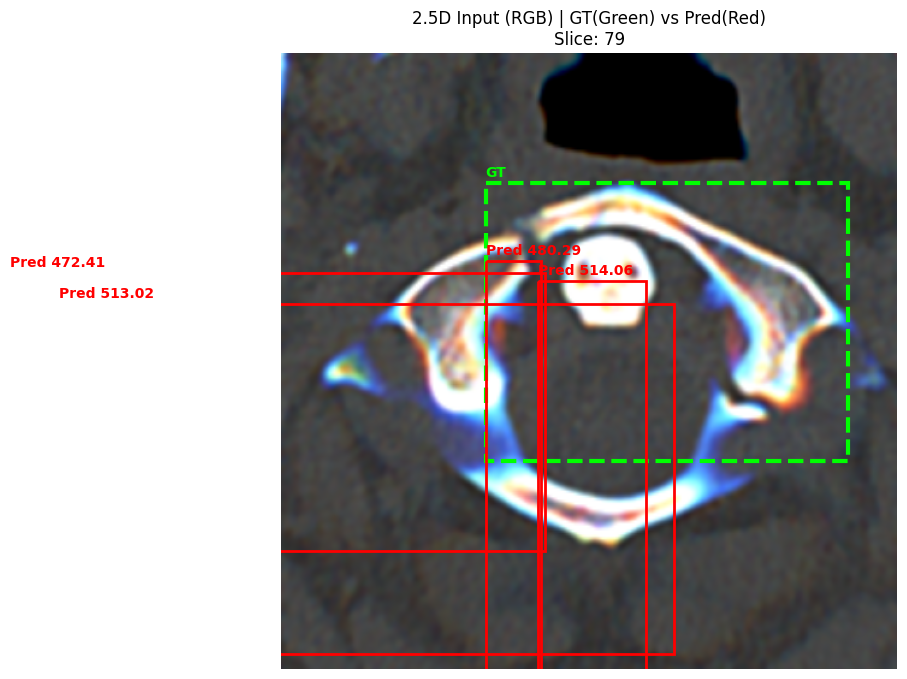

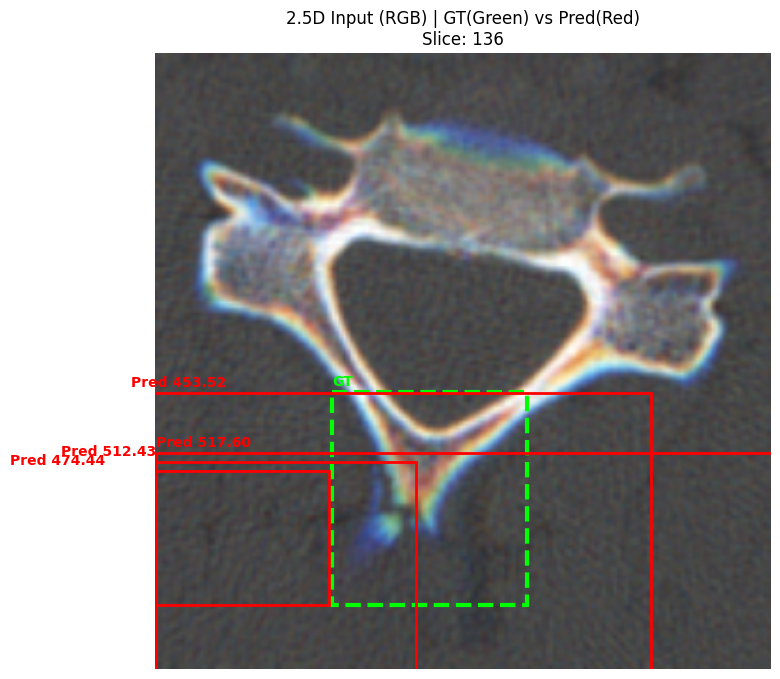

In [4]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast
import torchvision 
from ultralytics import YOLO

# ==========================================
# [설정]
# ==========================================
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
MANIFEST_PATH = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\det_train_manifest_balanced_1to1.csv'
MODEL_PATH = r'./runs/rsna_cropped_3ch_m/fold_1/weights/best.pt' # 경로 확인!
IMG_SIZE = 512
CONF_THRESHOLD = 0.25 
IOU_THRESHOLD = 0.5

def clean_and_parse_box(bbox_str):
    if not isinstance(bbox_str, str): return []
    # 데이터셋 만들 때 이미 리스트 문자열로 저장됨 ("[[...], ...]")
    try:
        return ast.literal_eval(bbox_str)
    except: return []

# [핵심] 수동 NMS 및 후처리 함수
def postprocess(pred, conf_thres=0.25, iou_thres=0.45):
    # YOLOv8 Output: (Batch, 4+Classes, Anchors)
    pred = pred.transpose(1, 2)
    
    output = []
    for image_pred in pred:
        # 1. Box 변환 (cx, cy, w, h) -> (x1, y1, x2, y2)
        x_center = image_pred[:, 0]
        y_center = image_pred[:, 1]
        width = image_pred[:, 2]
        height = image_pred[:, 3]
        
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2
        
        boxes = torch.stack([x1, y1, x2, y2], dim=1)
        
        # 2. Confidence & Class 점수
        if image_pred.shape[1] > 4:
            scores, class_ids = image_pred[:, 4:].max(dim=1)
        else:
            scores = torch.ones_like(x_center) # 클래스 정보가 없으면 1.0 가정
            class_ids = torch.zeros_like(x_center)

        # 3. Thresholding
        mask = scores > conf_thres
        boxes = boxes[mask]
        scores = scores[mask]
        class_ids = class_ids[mask]
        
        if boxes.shape[0] == 0:
            output.append(None)
            continue
            
        # 4. NMS (Non-Max Suppression)
        keep_indices = torchvision.ops.nms(boxes, scores, iou_thres)
        
        final_boxes = boxes[keep_indices]
        final_scores = scores[keep_indices]
        final_cls = class_ids[keep_indices]
        
        result = torch.cat([
            final_boxes, 
            final_scores.unsqueeze(1), 
            final_cls.float().unsqueeze(1)
        ], dim=1)
        
        output.append(result.cpu().numpy())
        
    return output

def visualize_inference():
    if not os.path.exists(MODEL_PATH):
        print(f"❌ 모델 파일이 없습니다: {MODEL_PATH}")
        return
    
    print(f"📦 모델 로딩 중: {MODEL_PATH}")
    yolo_wrapper = YOLO(MODEL_PATH)
    model = yolo_wrapper.model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()
    
    df = pd.read_csv(MANIFEST_PATH)
    # 골절 샘플 랜덤 추출
    val_df = df[(df['fold'] == 1) & (df['fracture'] == 1)].sample(n=5)
    
    print(f"🔍 검증 데이터 중 골절 샘플 5개를 추론합니다...")

    for idx, row in val_df.iterrows():
        full_path = os.path.join(BASE_DIR, row['file_path'])
        
        try:
            with np.load(full_path) as loaded:
                # Shape: (3, 512, 512)
                img_data = loaded['data'].astype(np.float32)
        except Exception as e:
            print(f"load error: {e}")
            continue

        # Inference
        input_tensor = torch.from_numpy(img_data).unsqueeze(0).to(device)
        with torch.no_grad():
            raw_output = model(input_tensor)
            if isinstance(raw_output, (tuple, list)):
                raw_output = raw_output[0]
            
            # Postprocess
            detections_list = postprocess(raw_output, CONF_THRESHOLD, IOU_THRESHOLD)
            detections = detections_list[0] if len(detections_list) > 0 else None

        # --- 시각화 (수정됨) ---
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        
        # [수정] 3채널(2.5D) -> RGB로 시각화
        # (C, H, W) -> (H, W, C)
        img_rgb = np.transpose(img_data, (1, 2, 0))
        img_rgb = np.clip(img_rgb, 0, 1) # 안전하게 0~1 사이로 클리핑
        
        ax.imshow(img_rgb)
        # [삭제] ax.imshow(img_data[3]...) -> 마스크 그리는 부분 삭제됨

        # --- GT (Green) ---
        gt_boxes = clean_and_parse_box(row['bbox'])
        for box in gt_boxes:
            if len(box) == 4:
                # 데이터셋은 Normalized (0~1) 좌표로 저장되어 있음
                nx, ny, nw, nh = box
                x, y, w, h = nx*IMG_SIZE, ny*IMG_SIZE, nw*IMG_SIZE, nh*IMG_SIZE
                
                rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='lime', facecolor='none', linestyle='--')
                ax.add_patch(rect)
                ax.text(x, y-5, 'GT', color='lime', fontweight='bold')

        # --- Pred (Red) ---
        if detections is not None:
            for det in detections:
                x1, y1, x2, y2, conf, cls = det
                w_p, h_p = x2 - x1, y2 - y1
                
                rect = patches.Rectangle((x1, y1), w_p, h_p, linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                ax.text(x1, y1-5, f"Pred {conf:.2f}", color='red', fontweight='bold')
        else:
             ax.text(10, 30, "No Detection", color='yellow', fontsize=12, backgroundcolor='black')

        ax.axis('off')
        ax.set_title(f"2.5D Input (RGB) | GT(Green) vs Pred(Red)\nSlice: {row['original_slice_number']}", fontsize=12)
        plt.show()

if __name__ == '__main__':
    visualize_inference()

In [4]:
import numpy as np
import pandas as pd
import os

# ==========================================
# [설정] 본인의 경로로 확인해 주세요
# ==========================================
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
MANIFEST_PATH = os.path.join(BASE_DIR, 'det_train_manifest_balanced_1to1.csv')

def check_raw_data():
    if not os.path.exists(MANIFEST_PATH):
        print("❌ 매니페스트 파일을 찾을 수 없습니다.")
        return

    # 1. 매니페스트 로드
    df = pd.read_csv(MANIFEST_PATH)
    
    # 골절 데이터 하나 샘플링
    sample = df[df['fracture'] == 1].iloc[0]
    full_path = os.path.join(BASE_DIR, sample['file_path'])
    
    print(f"📄 파일 경로: {sample['file_path']}")
    
    # 2. NPZ 파일 내부 확인
    try:
        with np.load(full_path) as loaded:
            img = loaded['data']
            print("\n--- [이미지 통계] ---")
            print(f"📊 값 범위(Min~Max): {img.min():.4f} ~ {img.max():.4f}")
            print(f"📐 데이터 모양(Shape): {img.shape}")
            
            # 채널별 평균 확인 (어느 채널이 튀는지 확인)
            for i in range(img.shape[0]):
                print(f"  - 채널 {i} 평균값: {np.mean(img[i]):.4f}")

    except Exception as e:
        print(f"❌ 이미지 로드 실패: {e}")

    print("\n--- [라벨 통계] ---")
    print(f"📍 매니페스트 좌표(BBox): {sample['bbox']}")
    print(f"🦴 뼈 레벨(C1~C7): {sample['ver_level']}")

if __name__ == '__main__':
    check_raw_data()

📄 파일 경로: detection_cropped_512\1.2.826.0.1.3680043.25238\0101.npz

--- [이미지 통계] ---
📊 값 범위(Min~Max): 0.0000 ~ 1.0000
📐 데이터 모양(Shape): (3, 512, 512)
  - 채널 0 평균값: 0.2992
  - 채널 1 평균값: 0.3020
  - 채널 2 평균값: 0.3049

--- [라벨 통계] ---
📍 매니페스트 좌표(BBox): [[0.08490566037735849, 0.1777246698113207, 0.7641509433962264, 0.6666149528301887]]
🦴 뼈 레벨(C1~C7): 0
